In [1]:
!pip install opencv-python numpy matplotlib


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [3]:
import zipfile

zip_path = "Task 1 - RGB Thermal Overlay Algorithm-20250622T060246Z-1-001.zip"
extract_path = "input-images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)


✅ Dataset extracted to: input-images


In [4]:
import os
from glob import glob

thermal_images = glob("input-images/**/*_T.JPG", recursive=True)
rgb_images = glob("input-images/**/*_Z.JPG", recursive=True)

print("Thermal images found:", len(thermal_images))
print("RGB images found:", len(rgb_images))


Thermal images found: 17
RGB images found: 18


In [5]:
import os

output_folder = "task_1_output"
os.makedirs(output_folder, exist_ok=True)
print("✅ Output folder ready:", output_folder)


✅ Output folder ready: task_1_output


In [7]:
def overlay_images(rgb_img, thermal_img_warped):
    thermal_colormap = cv2.applyColorMap(
        cv2.normalize(thermal_img_warped, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8),
        cv2.COLORMAP_JET
    )
    return cv2.addWeighted(rgb_img, 0.6, thermal_colormap, 0.4, 0)


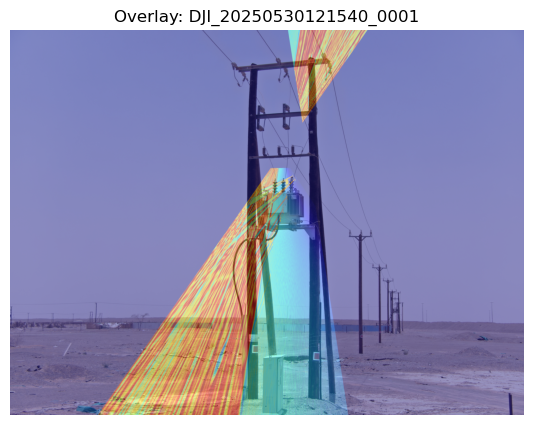

In [8]:
import matplotlib.pyplot as plt

# Select one sample pair
sample_thermal = thermal_images[0]
base_name = os.path.basename(sample_thermal).replace("_T.JPG", "")
sample_rgb = next((r for r in rgb_images if base_name in r), None)

# Read images
thermal_img = cv2.imread(sample_thermal, cv2.IMREAD_GRAYSCALE)
rgb_img = cv2.imread(sample_rgb)

# Resize thermal to match RGB size
thermal_resized = cv2.resize(thermal_img, (rgb_img.shape[1], rgb_img.shape[0]))

# Detect features
orb = cv2.ORB_create(500)
kp1, des1 = orb.detectAndCompute(thermal_resized, None)
kp2, des2 = orb.detectAndCompute(cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY), None)

# Match features
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Homography if enough matches
if len(matches) >= 4:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    if M is not None:
        thermal_warped = cv2.warpPerspective(thermal_resized, M, (rgb_img.shape[1], rgb_img.shape[0]))
        overlaid = overlay_images(rgb_img, thermal_warped)

        # Save and show
        output_path = os.path.join(output_folder, base_name + "_AT.JPG")
        cv2.imwrite(output_path, overlaid)

        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(overlaid, cv2.COLOR_BGR2RGB))
        plt.title(f"Overlay: {base_name}")
        plt.axis('off')
        plt.show()
    else:
        print("❌ Homography matrix not found.")
else:
    print("❌ Not enough matches to compute homography.")


In [9]:
processed = 0

for thermal_path in thermal_images:
    base_name = os.path.basename(thermal_path).replace("_T.JPG", "")
    rgb_path = next((r for r in rgb_images if base_name in r), None)

    if not rgb_path:
        print(f"❌ RGB not found for: {base_name}")
        continue

    thermal_img = cv2.imread(thermal_path, cv2.IMREAD_GRAYSCALE)
    rgb_img = cv2.imread(rgb_path)

    thermal_resized = cv2.resize(thermal_img, (rgb_img.shape[1], rgb_img.shape[0]))

    orb = cv2.ORB_create(500)
    kp1, des1 = orb.detectAndCompute(thermal_resized, None)
    kp2, des2 = orb.detectAndCompute(cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY), None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    if len(matches) < 4:
        print(f"⚠️ Not enough matches: {base_name}")
        continue

    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    if M is None:
        print(f"⚠️ Homography failed: {base_name}")
        continue

    thermal_warped = cv2.warpPerspective(thermal_resized, M, (rgb_img.shape[1], rgb_img.shape[0]))
    overlaid = overlay_images(rgb_img, thermal_warped)

    output_path = os.path.join(output_folder, base_name + "_AT.JPG")
    cv2.imwrite(output_path, overlaid)

    print(f"✅ Saved: {output_path}")
    processed += 1

print(f"\n🎉 Done! Processed and saved {processed} overlaid image(s).")


✅ Saved: task_1_output\DJI_20250530121540_0001_AT.JPG
❌ RGB not found for: DJI_20250530121638_0003
✅ Saved: task_1_output\DJI_20250530121724_0004_AT.JPG
✅ Saved: task_1_output\DJI_20250530121839_0006_AT.JPG
❌ RGB not found for: DJI_20250530121911_0007
❌ RGB not found for: DJI_20250530121928_0008
❌ RGB not found for: DJI_20250530121952_0009
❌ RGB not found for: DJI_20250530122012_0010
✅ Saved: task_1_output\DJI_20250530122042_0011_AT.JPG
✅ Saved: task_1_output\DJI_20250530122129_0012_AT.JPG
✅ Saved: task_1_output\DJI_20250530122315_0001_AT.JPG
✅ Saved: task_1_output\DJI_20250530122348_0002_AT.JPG
❌ RGB not found for: DJI_20250530122505_0001
❌ RGB not found for: DJI_20250530122528_0002
✅ Saved: task_1_output\DJI_20250530122558_0003_AT.JPG
❌ RGB not found for: DJI_20250530123002_0002
✅ Saved: task_1_output\DJI_20250530123037_0003_AT.JPG

🎉 Done! Processed and saved 9 overlaid image(s).
